In [6]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

population 1 31821850.0
supply_sum 1 17536670937.0
lonlat 1 Tokyo 139.69171 35.6895
cmy 1 551.0889824758774
--------------------------------------------
population 2 22058268.0
supply_sum 2 23669474886.0
lonlat 2 Delhi 77.21667 28.66667
cmy 2 1073.043218352411
--------------------------------------------
population 3 14540163.0
supply_sum 3 16667385039.0
lonlat 3 Shanghai 121.45806 31.22222
cmy 3 1146.2997381116015
--------------------------------------------
population 4 20178100.0
supply_sum 4 2428205971.5
lonlat 4 Ciudad de México (Mexico City) -99.141869 19.427318
cmy 4 120.3386826063901
--------------------------------------------
population 5 9675000.0
supply_sum 5 3775628136.375
lonlat 5 São Paulo -46.63611 -23.5475
cmy 5 390.2458022093023
--------------------------------------------
population 6 9448362.0
supply_sum 6 15150351672.0
lonlat 6 Kinki M.M.A. (Osaka) 135.553823 34.675834
cmy 6 1603.4897553671208
--------------------------------------------
population 7 8649229.0
supp

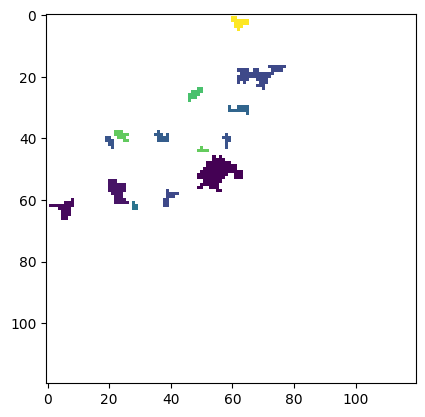

In [7]:
# this calculation should be resumed 
# after executing wsi/pre/updown/updwon_availability

city_len = 1860
ex_flg = False

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
pop_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
pop = np.fromfile(pop_path, dtype='float32').reshape(2160, 4320)
riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
cnt_dir = f'{h08dir}/global_city/dat/cty_cnt_/gpw4'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'

# intake
distance = 100
int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'

# lonlat
lonlat_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/WUP2018_300k_2010.txt'
with open(lonlat_path, "r") as input_file:
    lines = input_file.readlines()

CMY = []
world = np.zeros((2160, 4320))

for i in range(city_len):
    city_num = i+1
    msk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    int_path = f'{int_dir}/city_{city_num:08}.gl5'
    
    if not os.path.exists(prf_path):
        print(f'{i+1} is invalid prf')
        
    else:
        # population
        msk = np.fromfile(msk_path, dtype='float32').reshape(2160, 4320)
        pop_msk = np.ma.masked_where(msk != 1, pop)
        pop_sum = np.sum(pop_msk)
        msk_int = msk.astype(int)
        print('population', city_num, pop_sum)
        
        # rivout
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        supply = np.ma.masked_where(prf != 1, rivout)
        ibt = np.ma.masked_where(intake != 1, rivout)
        
        supply_sum = (np.sum(supply) + np.sum(ibt)) * 60 * 60 * 24 * 365 / (1000) # m3/year
        print('supply_sum', city_num, supply_sum)

        # lonlat
        line = lines[i]
        parts = line.split('\t')
        parts = [item.strip() for item in parts]
        cnt_lat = float(parts[1])
        cnt_lon = float(parts[2])
        city_name = parts[4].replace("\"", "").replace("?", "").replace("/", "")
        print('lonlat', city_num, city_name, cnt_lon, cnt_lat)

        # cmy = cubic meter(m3) per capita(cap-1) per year(year-1)
        cmy = supply_sum/pop_sum # m3/year/person
        CMY.append([city_num, cnt_lon, cnt_lat, cmy])

        # if world already has some value else of 0 at msk == 1, it's overlap and not added
        if np.sum(world[msk_int == 1]) < 1:
            world[msk_int == 1] = cmy
        else:
            print('overlap')
        print('cmy', city_num, cmy)
        print('--------------------------------------------')
        
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(135, 145, 30, 40)
region = world[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)
plt.imshow(region_masked)
plt.show()
    
if ex_flg is True:
    # save 1860 array
    cmy_array = np.array(CMY)
    savepath = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat_{distance}km.npy'
    np.save(savepath, cmy_array)
    print(f'{savepath} is saved')
    
    savepath = f'{h08dir}/wsi/dat/cmy/world_citygrid_{distance}km.npy'
    np.save(savepath, world)
    print(f'{savepath} is saved')